In [ ]:
import pencilbox as pb
import pandas as pd
import numpy as np
import time
import os
from datetime import date, datetime, timedelta
import json
import shutil 
!pip install pymysql
import pymysql

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import boto3
import io

!pip install matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import IsolationForest


import requests
from requests.exceptions import HTTPError

!pip install pandasql
import pandasql as ps

from tqdm.notebook import tqdm
CON_REDSHIFT = pb.get_connection("[Warehouse] Redshift")
CON_TRINO = pb.get_connection("[Warehouse] Trino")

In [ ]:
def read_sql_query(sql, con):
    max_tries = 3
    for attempt in range(max_tries):
        print(f"Read attempt: {attempt}...")
        try:
            start = time.time()
            df = pd.read_sql_query(sql, con)
            end = time.time()
            if (end - start) > 60:
                print("Time: ", (end - start) / 60, "min")
            else:
                print("Time: ", end - start, "s")
            return df
            break
        except BaseException as e:
            print(e)
            time.sleep(5)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 300)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
outliers_fraction = 0.01

# Fetch Sales

In [44]:
order_query = f"""
with
item_details as
    (select item_id, 
        (id.name || ' ' || id.variant_description) as item_name
            from lake_rpc.item_details id
    ),

item_mapping as
    (select distinct ipr.product_id,
        case when ipr.item_id is null then ipom_0.item_id else ipr.item_id end as item_id,
        case when ipr.item_id is not null then COALESCE(ipom.multiplier,1) else COALESCE(ipom_0.multiplier,1) end as multiplier
            
            from lake_rpc.item_product_mapping ipr

                left join
                    dwh.dim_item_product_offer_mapping ipom on ipom.product_id = ipr.product_id
                        and ipr.item_id = ipom.item_id
                left join
                    dwh.dim_item_product_offer_mapping ipom_0 on ipom_0.product_id = ipr.product_id
    ),

sales as
    (select 
        (oid.cart_checkout_ts_ist) as order_date,
        cl.name as city_name,
        rco.facility_id,
        oid.product_id,
        im.item_id,
        oid.cart_id,
        oid.dim_customer_key,
        ((unit_selling_price * 1.00)/im.multiplier) as item_selling_price,
        ((unit_mrp * 1.00)/im.multiplier) as item_selling_mrp,
        im.multiplier,
        oid.total_doorstep_return_quantity,
        ((oid.procured_quantity - oid.total_doorstep_return_quantity) * im.multiplier) as sales_quantity,
        (sales_quantity * item_selling_price) as sales_value,
        (sales_quantity * item_selling_mrp) as sales_value_mrp
        
            from dwh.fact_sales_order_item_details oid
            
                join item_mapping im on im.product_id = oid.product_id
                
                join lake_retail.console_outlet rco on rco.id = oid.outlet_id and business_type_id in (7)
                join lake_retail.console_location cl on cl.id = rco.tax_location_id
                
                    where (oid.cart_checkout_ts_ist between (current_date - 180 || ' 00:00:00')::timestamp and (current_date || ' 23:59:59')::timestamp)
                        and oid.is_internal_order = false
                        and (oid.order_type not ilike '%%internal%%' or oid.order_type is null)
                        and oid.procured_quantity > 0
                        and oid.order_current_status = 'DELIVERED'
    ),

final_sales as
    (select 
        date(order_date) as date_,
        city_name,
        facility_id,
        s.item_id, 
        item_name, 
        sum(sales_quantity)::int as sales_quantity,
        sum(sales_value) as sales_value,
        sum(sales_value_mrp) as sales_value_mrp
        
            from sales s
            
                join
                    item_details id on id.item_id = s.item_id
                    
                    where sales_quantity > 0
                    
                        group by 1,2,3,4,5
    )
    
        select * from final_sales where facility_id IN (1556)


            """

order_data = read_sql_query(order_query, CON_REDSHIFT)
order_data.head()

Read attempt: 0...
Time:  6.727274656295776 s


,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp
0,2023-01-12,Delhi,1556,10055448,Pepsi Black Soft Drink(Bottle) 500 ml - Rs 20,63,120.0,1260.0
1,2023-05-12,Delhi,1556,10001101,Amul Punchy Pepper Cheese Spread 200 g - Rs 102,1,97.0,102.0
2,2023-01-11,Delhi,1556,10001425,Gala Kingkong Grass Broom / Jhadu (Meghalaya G...,1,230.0,230.0
3,2023-05-28,Delhi,1556,10002392,Everest Chole Masala 100 g - Rs 84,3,234.0,234.0
4,2023-04-18,Delhi,1556,10002392,Everest Chole Masala 100 g - Rs 84,3,234.0,234.0


In [45]:
#order_df = pd.read_csv('sample-orders-data.csv')
order_df = order_data.copy()
order_df['Sales'] = order_df['sales_quantity']
order_df['Sales'].describe()

# order_df.head(2)

count    377743.000000
mean          4.800399
std          16.292887
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1449.000000
Name: Sales, dtype: float64

In [46]:
order_df.head()

,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,Sales
0,2023-01-12,Delhi,1556,10055448,Pepsi Black Soft Drink(Bottle) 500 ml - Rs 20,63,120.0,1260.0,63
1,2023-05-12,Delhi,1556,10001101,Amul Punchy Pepper Cheese Spread 200 g - Rs 102,1,97.0,102.0,1
2,2023-01-11,Delhi,1556,10001425,Gala Kingkong Grass Broom / Jhadu (Meghalaya G...,1,230.0,230.0,1
3,2023-05-28,Delhi,1556,10002392,Everest Chole Masala 100 g - Rs 84,3,234.0,234.0,3
4,2023-04-18,Delhi,1556,10002392,Everest Chole Masala 100 g - Rs 84,3,234.0,234.0,3


In [8]:
order_df.to_csv('order_df.csv', index = False)

# EDA

In [9]:
order_df.isna().sum()

date_               0
city_name           0
facility_id         0
item_id             0
item_name           0
sales_quantity      0
sales_value         0
sales_value_mrp    10
Sales               0
dtype: int64

In [10]:
order_df = order_df.dropna()

In [11]:
order_df['date_'] = pd.to_datetime(order_df['date_'])

In [12]:
order_df['date_'].min()

Timestamp('2023-04-05 00:00:00')

In [13]:
order_df['date_'].max()

Timestamp('2023-07-04 00:00:00')

In [14]:
order_df = order_df.sort_values(by='date_').reset_index(drop = True)

In [15]:
order_df.head()

,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,Sales
0,2023-04-05,Delhi,1556,10108010,Lay's Wafer Style - Salt with Pepper Potato Ch...,5,99.0,100.0,5
1,2023-04-05,Delhi,1556,10007518,Bisleri Packaged Water(Bottle) 5 l - Rs 70,16,1119.0,1120.0,16
2,2023-04-05,Delhi,1556,10001421,Fackelmann Plastic - Gas Lighter (Black) 1 uni...,1,146.0,199.0,1
3,2023-04-05,Delhi,1556,10106819,Enerzal Energy & Electrolyte Drink- ORS (Lime ...,1,33.0,33.0,1
4,2023-04-05,Delhi,1556,10004537,Haldiram's Panchratan Mixture Namkeen 200 g - ...,4,384.0,384.0,4


In [16]:
# row = int(len(order_df) * .8)
# print(int(row))
# x_train = order_df.head(row)
# x_test = order_df.tail(len(order_df) - row)

In [17]:
x_train = order_df.copy()

## Visualisation

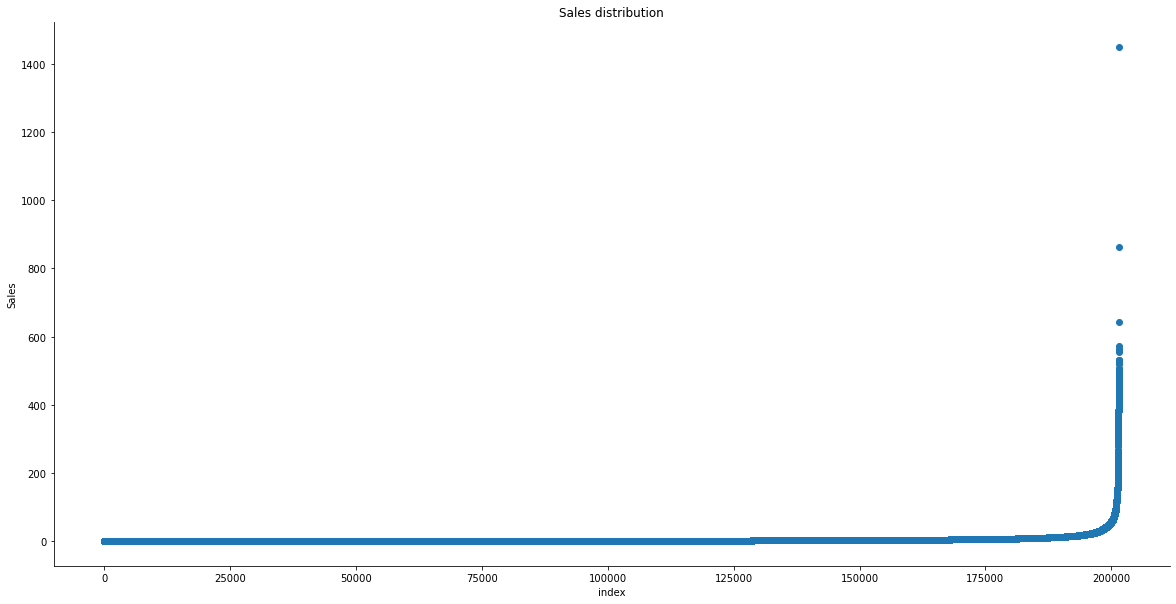

In [18]:
plt.subplots(figsize=(20,10))
plt.scatter(range(x_train.shape[0]), np.sort(x_train['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

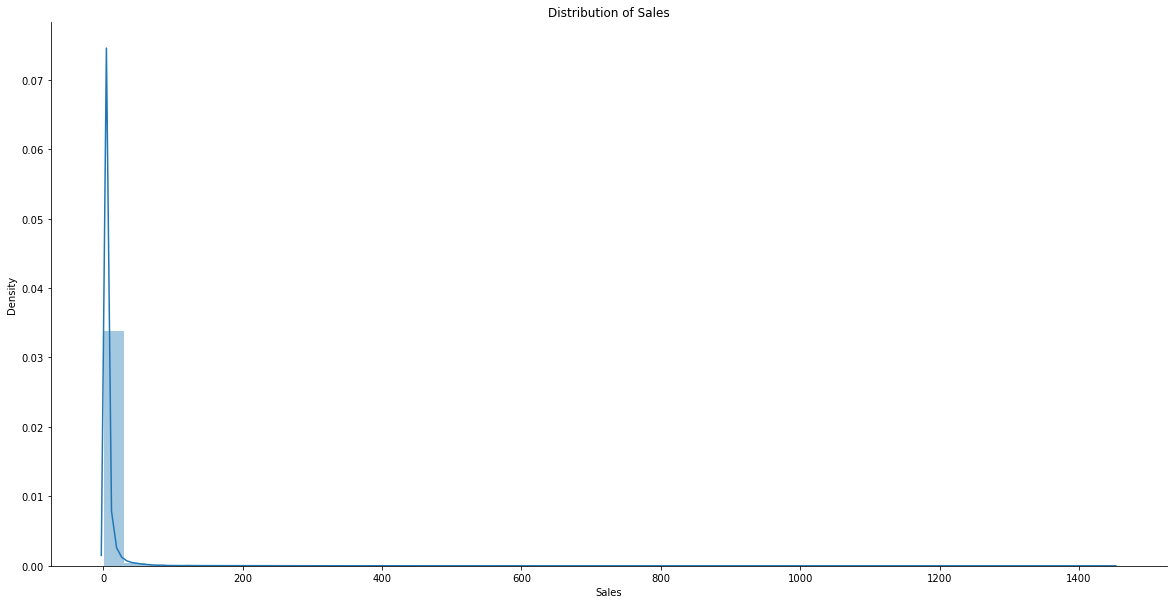

In [19]:
plt.subplots(figsize=(20,10))
sns.distplot(x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [20]:
x_train['Sales'].skew()

21.185064114541525

In [47]:
x_train = order_df.copy()
x_train = x_train[x_train['item_id'] == 10002288].reset_index().drop(columns = {'index'})

In [48]:
# log_x_train = x_train.copy()
# log_x_train['Sales'] = np.log(log_x_train['Sales'])

# plt.subplots(figsize=(20,10))
# plt.scatter(range(log_x_train.shape[0]), np.sort(log_x_train['Sales'].values))
# plt.xlabel('index')
# plt.ylabel('Sales')
# plt.title("Sales distribution")
# sns.despine()

In [49]:
# plt.subplots(figsize=(20,10))
# sns.distplot(log_x_train['Sales'])
# plt.title("Distribution of Sales")
# sns.despine()

In [50]:
# log_x_train['Sales'].skew()

In [51]:
# sqrt_x_train = x_train.copy()
# sqrt_x_train['Sales'] = np.sqrt(sqrt_x_train['Sales'])

# plt.subplots(figsize=(20,10))
# sns.distplot(sqrt_x_train['Sales'])
# plt.title("Distribution of Sales")
# sns.despine()

In [52]:
# plt.subplots(figsize=(20,10))
# sns.distplot(sqrt_x_train['Sales'])
# plt.title("Distribution of Sales")
# sns.despine()

In [53]:
# sqrt_x_train['Sales'].skew()

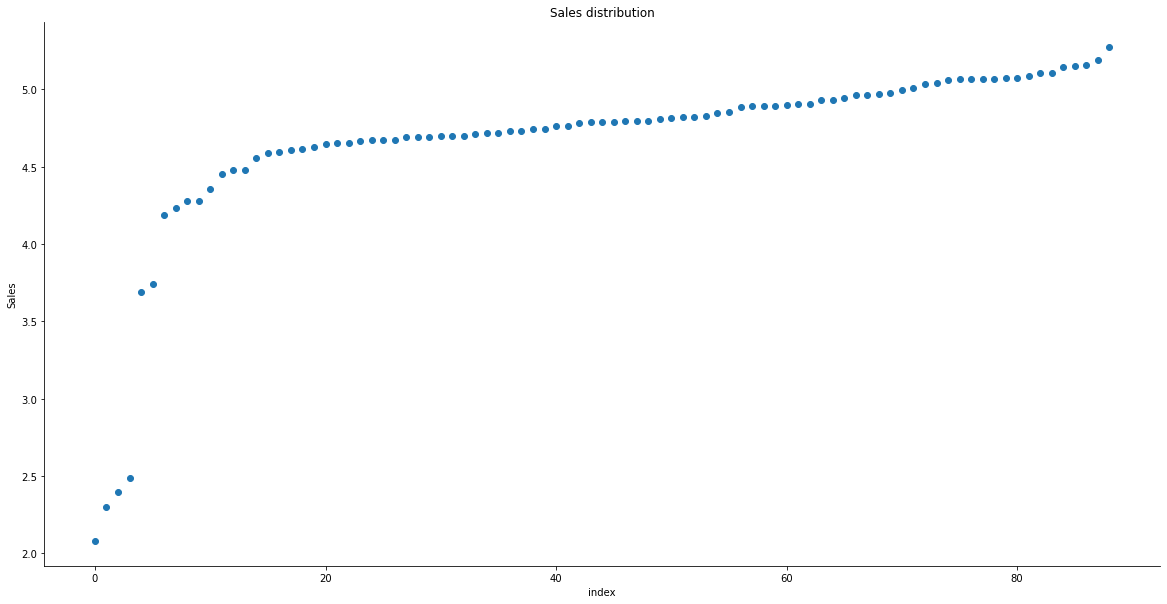

In [54]:
from scipy import stats
box_x_train = x_train.copy()
box_x_train['Sales'] = stats.boxcox(box_x_train['Sales'])[0]

plt.subplots(figsize=(20,10))
plt.scatter(range(log_x_train.shape[0]), np.sort(log_x_train['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

In [55]:
# box_x_train

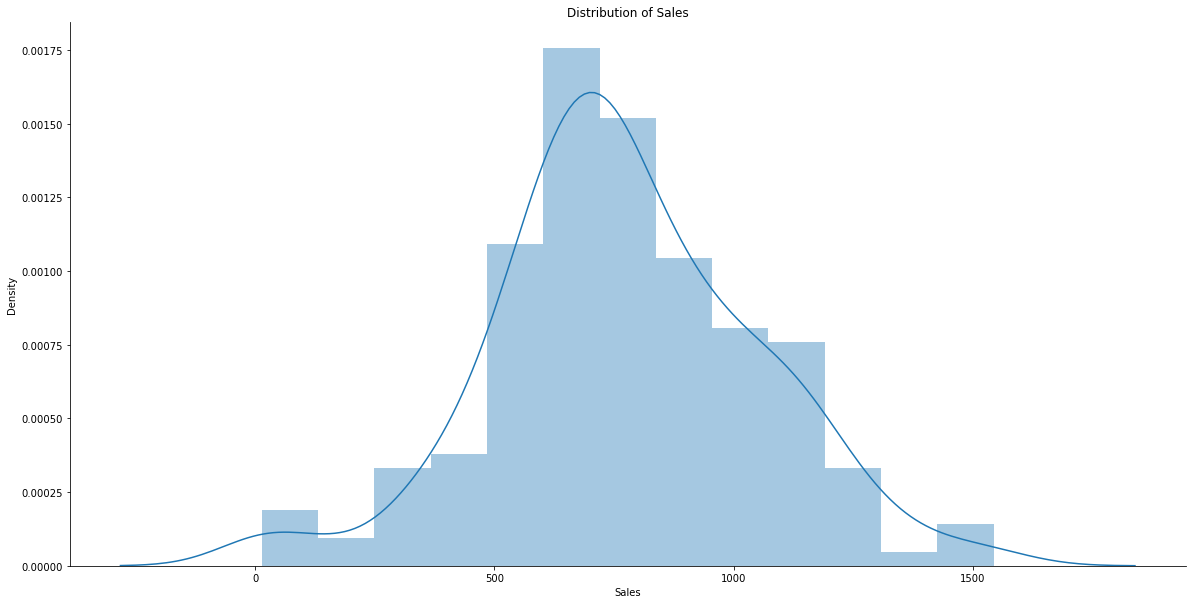

In [56]:
plt.subplots(figsize=(20,10))
sns.distplot(box_x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [57]:
box_x_train['Sales'].skew()

-0.006110987059128582

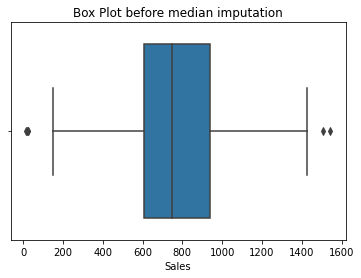

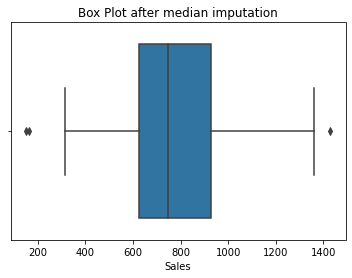

In [58]:
#median imputation

sns.boxplot(box_x_train['Sales'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = box_x_train['Sales'].quantile(0.25)
q3 = box_x_train['Sales'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(box_x_train['Sales'])
for i in box_x_train['Sales']:
    if i > Upper_tail or i < Lower_tail:
            box_x_train['Sales'] = box_x_train['Sales'].replace(i, med)
sns.boxplot(box_x_train['Sales'])
plt.title("Box Plot after median imputation")
plt.show()

In [59]:
# zscore_x_train = x_train.copy()
# zscore_x_train['zscore'] = (zscore_x_train['Sales'] - zscore_x_train['Sales'].mean())/zscore_x_train['Sales'].std(ddof=0)

# plt.scatter(range(zscore_x_train.shape[0]), np.sort(zscore_x_train['zscore'].values))
# plt.xlabel('index')
# plt.ylabel('Sales')
# plt.title("Sales distribution")
# sns.despine()

In [60]:
# sns.distplot(zscore_x_train['zscore'])
# plt.title("Distribution of Sales")
# sns.despine()

In [61]:
# zscore_x_train['zscore'].skew()

# ignore

In [62]:
# sqrt_x_train['zscore'] = np.sqrt(sqrt_x_train['zscore'])

# plt.scatter(range(sqrt_x_train.shape[0]), np.sort(sqrt_x_train['zscore'].values))
# plt.xlabel('index')
# plt.ylabel('zscore')
# plt.title("zscore distribution")
# sns.despine()

In [63]:
# sns.distplot(sqrt_x_train['zscore'])
# plt.title("Distribution of zscore")
# sns.despine()

In [64]:
# mean = sqrt_x_train[~sqrt_x_train['zscore'].isna()]['zscore'].mean()
# sqrt_x_train['zscore'] = sqrt_x_train['zscore'].fillna(mean)

# plt.scatter(range(sqrt_x_train.shape[0]), np.sort(sqrt_x_train['zscore'].values))
# plt.xlabel('index')
# plt.ylabel('zscore')
# plt.title("zscore distribution")
# sns.despine()

In [65]:
# sns.distplot(sqrt_x_train['zscore'])
# plt.title("Distribution of zscore")
# sns.despine()

In [66]:
# sqrt_x_train['zscore'].skew()

In [67]:
# sns.distplot(order_df['Sales'])
# plt.title("Distribution of Sales")
# sns.despine()

In [68]:
# print("Skewness: %f" % order_df['Sales'].skew())
# print("Kurtosis: %f" % order_df['Sales'].kurt())

In [69]:
# order_df['Profit'].describe()

In [70]:
# plt.scatter(range(order_df.shape[0]), np.sort(order_df['Profit'].values))
# plt.xlabel('index')
# plt.ylabel('Profit')
# plt.title("Profit distribution")
# sns.despine()

In [71]:
# sns.distplot(order_df['Profit'])
# plt.title("Distribution of Profit")
# sns.despine()

In [72]:
# print("Skewness: %f" % order_df['Profit'].skew())
# print("Kurtosis: %f" % order_df['Profit'].kurt())

# modeling

In [73]:
# isolation_forest = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = float(0.1),max_features = 1.0)
# isolation_forest.fit(zscore_x_train['zscore'].values.reshape(-1, 1))

# xx = np.linspace(zscore_x_train['zscore'].min(), zscore_x_train['zscore'].max(), len(zscore_x_train)).reshape(-1,1)
# anomaly_score = isolation_forest.decision_function(xx)
# outlier = isolation_forest.predict(xx)

# plt.figure(figsize=(10,4))
# plt.plot(xx, anomaly_score, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier==-1, color='r', 
#                  alpha=.4, label='outlier region')
# plt.legend()
# plt.ylabel('anomaly score')
# plt.xlabel('zscore')
# plt.show();

In [74]:
# isolation_forest = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = float(0.1),max_features = 1.0)
# isolation_forest.fit(log_x_train['Sales'].values.reshape(-1, 1))

# xx = np.linspace(log_x_train['Sales'].min(), log_x_train['Sales'].max(), len(log_x_train)).reshape(-1,1)
# anomaly_score = isolation_forest.decision_function(xx)
# outlier_log = isolation_forest.predict(xx)

# plt.figure(figsize=(10,4))
# plt.plot(xx, anomaly_score, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier_log==-1, color='r', 
#                  alpha=.4, label='outlier region')
# plt.legend()
# plt.ylabel('anomaly score')
# plt.xlabel('Sales')
# plt.show();

In [75]:
# isolation_forest = IsolationForest(n_estimators = 200, max_samples = 'auto', contamination = float(0.1),max_features = 1.0)
# isolation_forest.fit(box_x_train['Sales'].values.reshape(-1, 1))

# xx = np.linspace(box_x_train['Sales'].min(), box_x_train['Sales'].max(), len(box_x_train)).reshape(-1,1)
# anomaly_score = isolation_forest.decision_function(xx)
# outlier_box = isolation_forest.predict(xx)
# box_x_train['isolation_forest'] = outlier_box

# plt.figure(figsize=(20,10))
# plt.plot(xx, anomaly_score, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier_box==-1, color='r', 
#                  alpha=.4, label='outlier region')
# plt.legend()
# plt.ylabel('anomaly score')
# plt.xlabel('Sales')
# plt.show();

In [76]:
# box_x_train.head()

In [77]:
box_x_train['hours'] = box_x_train['date_'].dt.hour
box_x_train['month'] = box_x_train['date_'].dt.month
box_x_train['DayOfTheWeek'] = box_x_train['date_'].dt.dayofweek
box_x_train['WeekDay'] = (box_x_train['DayOfTheWeek'] < 5).astype(int)

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
box_x_train.head()

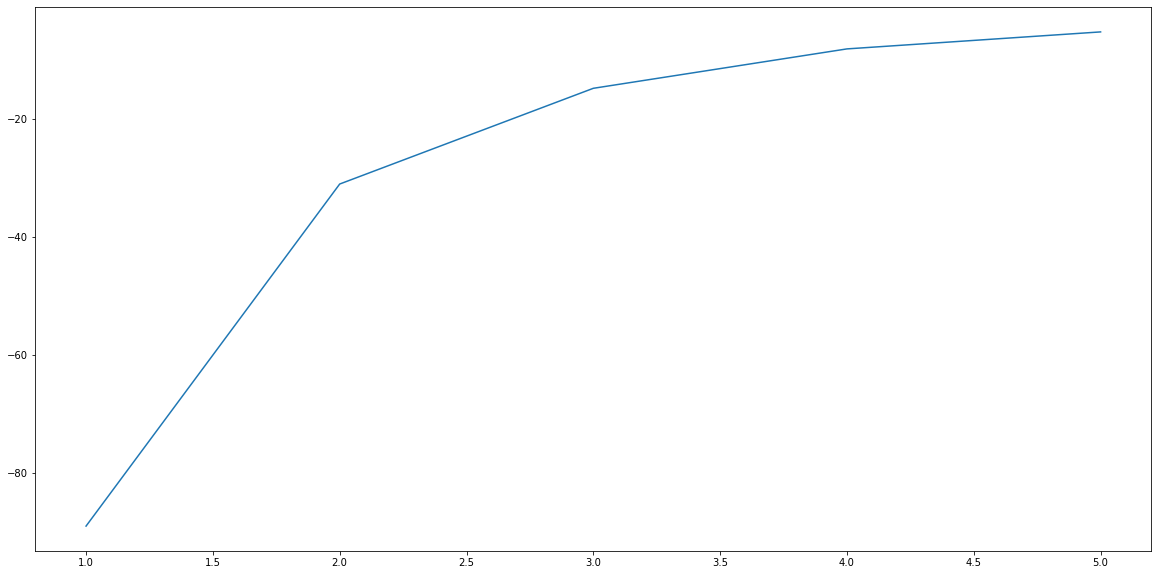

In [36]:
# Take useful feature and standardize them
# data = box_x_train[['Sales', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
data = box_x_train[['Sales','hours']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
n_cluster = range(1, 6)
kmeans = [KMeans(n_clusters=i, init='k-means++',n_init=20, random_state=42, algorithm='auto', max_iter=500).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(n_cluster, scores)
plt.show()

In [37]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
box_x_train['cluster'] = kmeans[2].predict(data)
box_x_train['cluster'].value_counts()

1    53
0    25
2    11
Name: cluster, dtype: int64

In [38]:
from sklearn import metrics
metrics.silhouette_score(data, kmeans[2].labels_,metric='euclidean')

0.5971218711136818

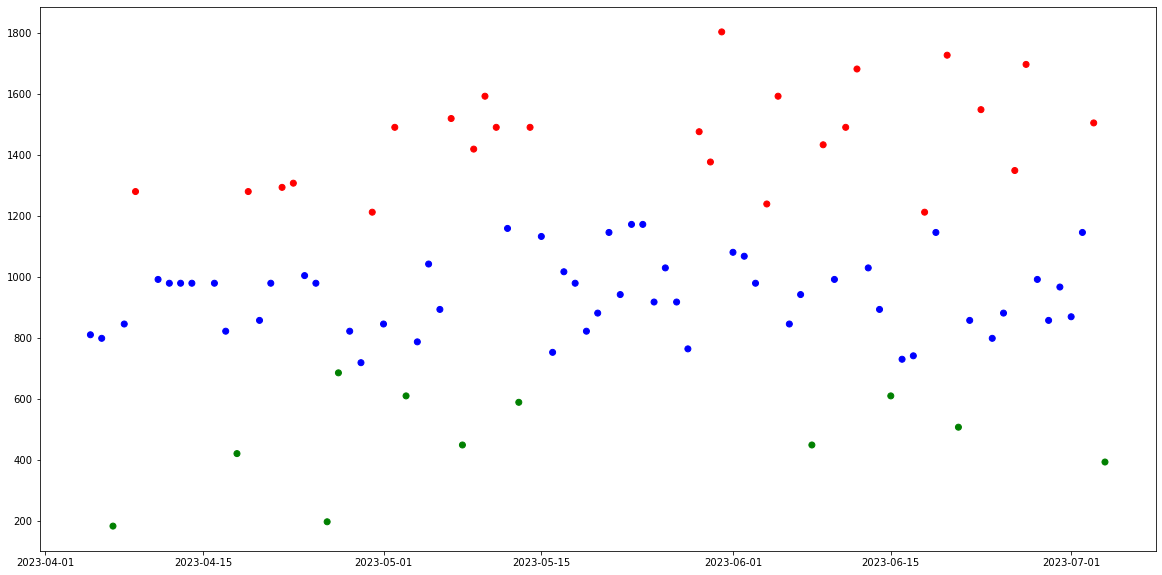

In [39]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['Sales'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
plt.show()

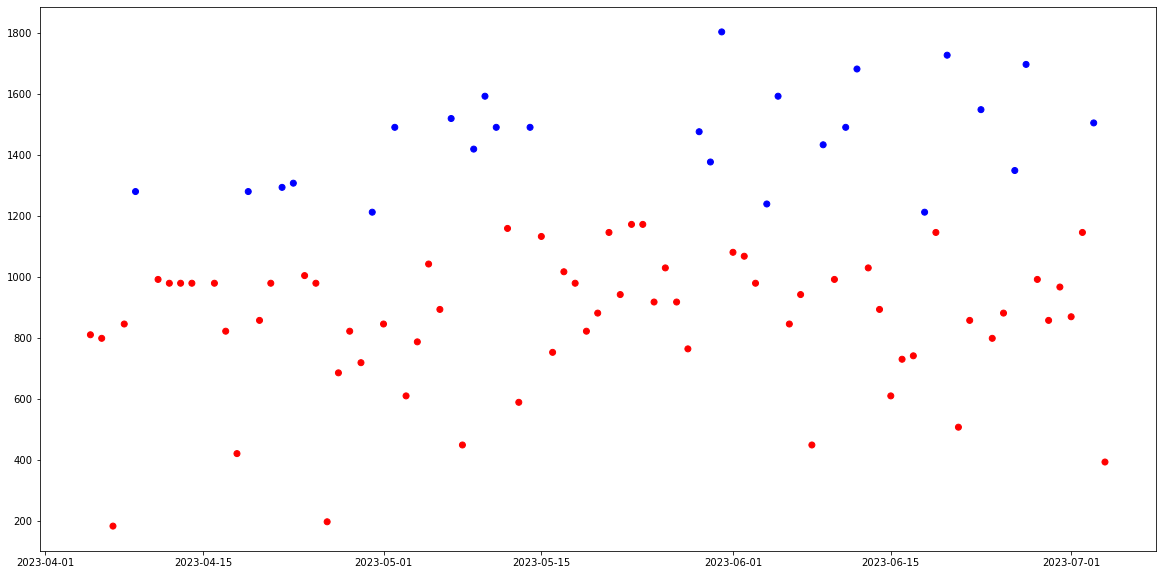

In [40]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2)
 
# Fit the GMM model for the dataset
# which expresses the dataset as a
# mixture of 3 Gaussian Distribution
gmm.fit(box_x_train['cluster'].values.reshape(-1, 1))
 
# Assign a label to each sample
labels = gmm.predict(box_x_train['cluster'].values.reshape(-1, 1))
box_x_train['labels']= labels
 
# plot three clusters in same plot
plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue'}
plt.scatter(box_x_train['date_'], box_x_train['Sales'], c = box_x_train['labels'].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps = 2, metric='euclidean', min_samples = 3)
# outlier_box = dbscan.fit_predict(box_x_train['Sales'].values.reshape(-1, 1))

# box_x_train['dbscan'] = outlier_box
# print(box_x_train['dbscan'].value_counts().sort_values(ascending=False))

In [ ]:
# fig, ax = plt.subplots(figsize=(20,10))
# colors = {0:'red', 1:'blue', 2:'green'}
# ax.scatter(box_x_train['date_'], box_x_train['Sales'], c=box_x_train['dbscan'])
# plt.show()

In [ ]:
# oneclasssvm = OneClassSVM()
# oneclasssvm.fit(box_x_train['Sales'].values.reshape(-1, 1))

# xx = np.linspace(box_x_train['Sales'].min(), box_x_train['Sales'].max(), len(box_x_train)).reshape(-1,1)
# anomaly_score = oneclasssvm.decision_function(xx)
# outlier = oneclasssvm.predict(xx)
# box_x_train['oneclasssvm'] = outlier

# plt.figure(figsize=(20,10))
# plt.plot(xx, anomaly_score, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier==-1, color='r', 
#                  alpha=.4, label='outlier region')
# plt.legend()
# plt.ylabel('anomaly score')
# plt.xlabel('Sales')
# plt.show();

# rest

In [41]:
box_x_train.head()

,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,Sales,hours,month,DayOfTheWeek,WeekDay,cluster,labels
0,2023-04-05,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,106,1458.0,1696.0,809.458860,0,4,2,1,1,0
1,2023-04-06,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,105,1483.0,1728.0,797.818807,0,4,3,1,1,0
2,2023-04-07,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,40,591.0,689.0,182.286484,0,4,4,1,2,0
3,2023-04-08,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,109,1640.0,1921.0,844.725991,0,4,5,0,1,0
4,2023-04-09,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,143,2090.0,2435.0,1278.970627,0,4,6,0,0,1


In [42]:
box_x_train[box_x_train['cluster'] == 1]

,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,Sales,hours,month,DayOfTheWeek,WeekDay,cluster,labels
0,2023-04-05,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,106,1458.0,1696.0,809.458860,0,4,2,1,1,0
1,2023-04-06,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,105,1483.0,1728.0,797.818807,0,4,3,1,1,0
3,2023-04-08,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,109,1640.0,1921.0,844.725991,0,4,5,0,1,0
5,2023-04-11,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,121,1705.0,1985.0,990.881660,0,4,1,1,1,0
6,2023-04-12,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,12,166.0,192.0,978.397116,0,4,2,1,1,0
7,2023-04-13,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,10,147.0,190.0,978.397116,0,4,3,1,1,0
8,2023-04-14,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,11,160.0,209.0,978.397116,0,4,4,1,1,0
9,2023-04-16,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,8,134.0,160.0,978.397116,0,4,6,0,1,0
10,2023-04-17,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,107,1720.0,2075.0,821.156913,0,4,0,1,1,0
13,2023-04-20,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,110,1629.0,1980.0,856.596512,0,4,3,1,1,0


In [43]:
box_x_train[box_x_train['cluster'] == 2]

,date_,city_name,facility_id,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,Sales,hours,month,DayOfTheWeek,WeekDay,cluster,labels
2,2023-04-07,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,40,591.0,689.0,182.286484,0,4,4,1,2,0
11,2023-04-18,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,69,1051.0,1292.0,419.930331,0,4,1,1,2,0
19,2023-04-26,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,42,616.0,756.0,196.435241,0,4,2,1,2,0
20,2023-04-27,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,95,1394.0,1710.0,684.667485,0,4,3,1,2,0
26,2023-05-03,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,88,1454.0,1774.0,609.079807,0,5,2,1,2,0
31,2023-05-08,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,72,1061.0,1296.0,448.168460,0,5,0,1,2,0
36,2023-05-13,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,86,1356.0,1738.0,588.048419,0,5,5,0,2,0
62,2023-06-08,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,72,918.0,1152.0,448.168460,0,6,3,1,2,0
69,2023-06-15,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,88,1939.0,2581.0,609.079807,0,6,3,1,2,0
75,2023-06-21,Delhi,1556,10002288,Hybrid Tomato Tomato - Hybrid,78,2033.0,2706.0,506.513355,0,6,2,1,2,0


In [ ]:
plt.scatter(range(box_x_train[box_x_train['Outlier'] != -1].shape[0]), np.sort(box_x_train[box_x_train['Outlier'] != -1]['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

In [ ]:
sns.distplot(box_x_train[box_x_train['Outlier'] != -1]['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [ ]:
print('--- Pre ---')
print("Skewness: %f" % box_x_train['Sales'].skew())
print("Kurtosis: %f" % box_x_train['Sales'].kurt())

print('\n--- Post ---')
print("Skewness: %f" % box_x_train[box_x_train['Outlier'] != -1]['Sales'].skew())
print("Kurtosis: %f" % box_x_train[box_x_train['Outlier'] != -1]['Sales'].kurt())

In [ ]:
box_x_train.head()

In [ ]:
sample = box_x_train[box_x_train['item_id'] == 10005109]
sample.head()

In [ ]:
import seaborn as sns

plt.subplots(figsize=(20,10))
sns.scatterplot(x = sample['date_'], y = sample['sales_quantity'], data = sample, hue='Outlier')
plt.show()
# plt.scatter(range(box_x_train[box_x_train['Outlier'] != -1].shape[0]), np.sort(box_x_train[box_x_train['Outlier'] != -1]['Sales'].values))
#plt.scatter(x = box_x_train[box_x_train['item_id'] == 10005109][['date_']], y = box_x_train[box_x_train['item_id'] == 10005109][['sales_quantity']],)

In [ ]:
box_x_train[box_x_train['Outlier'] == -1]

In [ ]:
len(box_x_train[box_x_train['Outlier'] == -1])

In [ ]:
len(box_x_train[box_x_train['Outlier'] == 1])

In [ ]:
#log_x_train.shape, log_x_train['Product ID'].nunique()

In [ ]:
# check_df = log_x_train.groupby(['Product ID','City']).agg({'Order ID':'nunique'}).reset_index()
# check_df[check_df['Order ID'] > 3]

In [ ]:
box_x_train.head()

In [ ]:
test_df = box_x_train[box_x_train['date_'] > pd.to_datetime('2023-30-06', format='%Y-%d-%m')]

In [ ]:
test_df[test_df['Outlier'] == -1]